# Implementing Neural Networks in Theano & Lasagne

In this notebook we will implement a simple Neural Network from scratch. This tutorial combines and adapts elements from a tutorial by [WildML](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/) and by [Marekei](http://www.marekrei.com/blog/theano-tutorial/).



In [1]:
import os

os.environ['THEANO_FLAGS'] = 'device=gpu1, floatX=float32'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'    # we need this for profiling theano functions

import matplotlib.pyplot as plt
import numpy as np
import numpy
import sklearn
import sklearn.datasets
import matplotlib
import theano
import theano.tensor as T

import pydot
from IPython.display import Image
from IPython.display import SVG
import timeit

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '17187' (I am process '17988')
Using gpu device 1: Tesla K80 (CNMeM is disabled, cuDNN 4007)


### Introduction to Theano Syntax

Here is simple toy example in which we compute the dot-product between a given
vector $w$ and a variable $x$:

In [2]:
# We first define a Theano variable x to be a vector of 32-bit floats, 
# and give it the name ‘x’
x = theano.tensor.fvector('x')

# Next, we create a Theano variable w, assign its value to be 
# vector [0.2, 0.7], and name it ‘W’:
w = theano.shared(np.asarray([0.2, 0.7]), 'w')

# We define y to be the sum of all elements in the element-wise 
# multiplication of x and W:
y = (x * w).sum()
 
# We define a Theano function f, which takes as input x and outputs y:
f = theano.function([x], y)
 
# Then call this function, giving as the argument vector [1.0, 1.0], 
# essentially setting the value of variable x:
output = f([1.0, 1.0])
print output

0.9


### Theano Variables

We can define variables which don’t have any values yet. Normally, these would be used for inputs to our network. The variables have to be of a specific type though. For example, here we define variable x to be a vector of 32-bit floats, and give it name ‘x’:

> x = theano.tensor.fvector('x')

The names are generally useful for debugging and informative error messages. Theano won’t have access to your Python variable names, so you have to assign explicit Theano names for each variable if you want them to be referred to as something more useful than just “a tensor”.

There are a number of different variable types available, just have a look at the list here. Some of the more popular ones include:

| Constructor  | dtype   | ndim |
|--------------|---------|------|
| fvector      | float32 | 1    |
| ivector      | int32   | 1    |
| fscalar      | float32 | 0    |
| fmatrix      | float32 | 2    |
| ftensor3     | float32 | 3    |
| dtensor3     | float64 | 3    |
| ftensor4     | float32 | 4    |
| dtensor4     | float64 | 4    |

You can also define a generic vector (or tensor) and set the type with an argument:

> x = theano.tensor.vector('x', dtype=float32)

If you don’t set the dtype, you will create vectors of type config.floatX.

### Shared Variables

We can also define shared variables, which are shared between different functions and different function calls. Normally, these would be used for weights in our neural network. Theano will automatically try to move shared variables to the GPU, provided one is available, in order to speed up computation.

Here we define a shared variable and set its value to [0.2, 0.7].

> W = theano.shared(numpy.asarray([0.2, 0.7]), 'W')

The values in shared variables can be accessed and modified outside of our Theano functions using these commands:

> W.get_value()

> W.set_value([0.1, 0.9])

### Functions

Theano functions are basically hooks for interacting with the symbolic graph. Commonly, we use them for passing input into our network and collecting the resulting output.

Here we define a Theano function f that takes x as input and returns y as output:

> f = theano.function([x], y)

The first parameter is the list of input variables, and the second parameter is the list of output variables. Although if there’s only one output variable (like now) we don’t need to make it into a list.

When we construct a function, Theano takes over and performs some of its own magic. It builds the computational graph and optimises it as much as possible. It restructures mathematical operations to make them faster and more stable, compiles some parts to C, moves some tensors to the GPU, etc.

Theano compilation can be controlled by setting the value of mode in the environement variable THEANO_FLAGS:

* FAST_COMPILE – Fast to compile, slow to run. Python implementations only, minimal graph optimisation.
* FAST_RUN – Slow to compile, fast to run. C implementations where available, full range of optimisations

The parameter THEANO_FLAGS can be set at the beginning of the script, see the header of this notebook.

### Minimum Training Example

Here’s a minimal script for actually training something in Theano. We will be training the weights in W using gradient descent, so that the result from the model would be 20 instead of the original 0.9.

In [3]:
x = theano.tensor.fvector('x')

# We create a second input variable called target, which will act 
# as the target value we use for training:
target = theano.tensor.fscalar('target')
 
W = theano.shared(numpy.asarray([0.2, 0.7]), 'W')
y = (x * W).sum()

# In order to train the model, we need a cost function. Here we use a 
# simple squared distance from the target:
cost = theano.tensor.sqr(target - y)

# To calculate the partial gradients for the parameters with respect to the 
# cost function we call the grad function. First argument: the real-valued 
# cost, second argument : a list of all the variables we want gradients for
gradients = theano.tensor.grad(cost, [W])

# Now let’s define a symbolic variable for what the updated version of the 
# parameters will look like. Using gradient descent, the update rule is to 
# subtract the gradient, multiplied by the learning rate:
W_updated = W - (0.1 * gradients[0])

# And next we create a list of updates. More specifically, a list of tuples 
# where the first element is the variable we want to update, and the second 
# element is a variable containing the values that we want the first variable 
# to contain after the update. This is just a syntax that Theano requires.
updates = [(W, W_updated)]

# Theano.function now takes two input arguments – one for the input vector, 
# and another for the target value used for training. And the list of updates 
# also gets attached to the function as well. Every time this function is 
# called, we pass in values for x and target, get back the value for y as 
# output, and Theano performs all the updates in the update list.
f = theano.function([x, target], y, updates=updates)

# In order to train the parameters, we repeatedly call this function 
# (10 times in this case). Normally, we’d pass in different examples from 
# our training data, but for this example we use the same x=[1.0, 1.0] and 
# target=20 each time:
for i in xrange(10):
    output = f([1.0, 1.0], 20.0)
    print output

0.9
8.54000011384
13.1240001366
15.874400123
17.5246400984
18.5147840738
19.1088704531
19.4653222772
19.6791933695
19.8075160236


### Useful Operations

This covers the basic logic behind building models with Theano. The example was very simple, but we are free to define increasingly complicated networks, as long as we use Theano-specific functions. Now let’s look at some of these building blocks that we have available.

**Evaluate the value of a Theano variable**

The eval() function forces the Theano variable to calculate and return its actual (numerical) value. If we try to just print the variable a, we only print its name. But if we use eval(), we get the actual square matrix that it is initialised to.

In [4]:
a = theano.shared(numpy.asarray([[1.0,2.0],[3.0,4.0]]), 'a')
a.eval()

array([[ 1.,  2.],
       [ 3.,  4.]])

This eval() function isn’t really used for building models, but it can be useful for debugging and learning how Theano works. In the examples below, I will be using the matrix a and the eval() function to print the value of each variable and demonstrate how different operations work.

**Basic element-wise operations: + – * /**

In [5]:
c = ((a + a) / 4.0)
c.eval()

array([[ 0.5,  1. ],
       [ 1.5,  2. ]])

**Dot product**

In [6]:
c = theano.tensor.dot(a, a)
c.eval()

array([[  7.,  10.],
       [ 15.,  22.]])

**Activation functions**

In [7]:
c = theano.tensor.nnet.sigmoid(a)
c.eval()

array([[ 0.73105858,  0.88079708],
       [ 0.95257413,  0.98201379]])

In [8]:
c = theano.tensor.tanh(a)
c.eval()

array([[ 0.76159416,  0.96402758],
       [ 0.99505475,  0.9993293 ]])

In [9]:
c = theano.tensor.nnet.softmax(a)
c.eval()

array([[ 0.26894142,  0.73105858],
       [ 0.26894142,  0.73105858]])

**Sum**

In [10]:
c = a.sum()
c.eval()

array(10.0)

In [11]:
c = a.sum(axis=1)
c.eval()

array([ 3.,  7.])

**Max**

In [12]:
c = a.max()
c.eval()

array(4.0)

In [13]:
c = a.max(axis=1)
c.eval()

array([ 2.,  4.])

**Argmax**

In [14]:
c = theano.tensor.argmax(a)
c.eval()

array(3)

In [15]:
c = theano.tensor.argmax(a, axis=1)
c.eval()

array([1, 1])

**Reshape**

We sometimes need to change the dimensions of a tensor and reshape() allows us to do that. It takes as input a tuple containing the new shape and returns a new tensor with that shape. In the first example below, we shape a square matrix into a 1×4 matrix. In the second example, we use -1 which means “as big as the dimension needs to be”.

In [16]:
a = theano.shared(numpy.asarray([[1,2],[3,4]]), 'a')
c = a.reshape((1,4))
c.eval()

array([[1, 2, 3, 4]])

In [17]:
c = a.reshape((-1,))
c.eval()

array([1, 2, 3, 4])

**Zeros-like, ones-like**

These functions create new tensors with the same shape but all values set to zero or one.

In [18]:
c = theano.tensor.zeros_like(a)
c.eval()

array([[0, 0],
       [0, 0]])

**Reorder the tensor dimensions**

Sometimes we need to reorder the dimensions in a tensor. In the examples below, the dimensions in a two-dimensional matrix are first swapped. Then, ‘x’ is used to create a brand new dimension.

In [19]:
a.eval()

array([[1, 2],
       [3, 4]])

In [20]:
c = a.dimshuffle((1,0))
c.eval()

array([[1, 3],
       [2, 4]])

In [21]:
c = a.dimshuffle(('x',0,1))
c.eval()

array([[[1, 2],
        [3, 4]]])

**Indexing**

Using Python indexing tricks can make life so much easier. In the example below, we make a separate list b containing line numbers, and use it to construct a new matrix which contains exactly the lines we want from the original matrix. This can be useful when dealing with word embeddings – we can put word ids into a list and use this to retrieve exactly the correct sequence of embeddings from the whole embedding matrix.

In [22]:
a = theano.shared(numpy.asarray([[1.0,2.0],[3.0,4.0]]), 'a')
a.eval()

array([[ 1.,  2.],
       [ 3.,  4.]])

In [23]:
b = [1,1,0]
c = a[b]
c.eval()

array([[ 3.,  4.],
       [ 3.,  4.],
       [ 1.,  2.]])

For assignment, we can’t do this:

In [24]:
a[0] = [0.0, 0.0]

TypeError: 'TensorSharedVariable' object does not support item assignment

But instead, we can use set_subtensor(), which takes as arguments the selection of the original matrix that we want to reassign, and the value we want to assign it to. It returns a new tensor that has the corresponding values modified.

In [25]:
c = theano.tensor.set_subtensor(a[0],[0.0, 0.0])
c.eval()

array([[ 0.,  0.],
       [ 3.,  4.]])

### Simple binary classification problem

We have two classes (red and blue) and want to train a Neural Network classifier that separates the two. In the first iteration we will train a simple sigmoidal classifier.

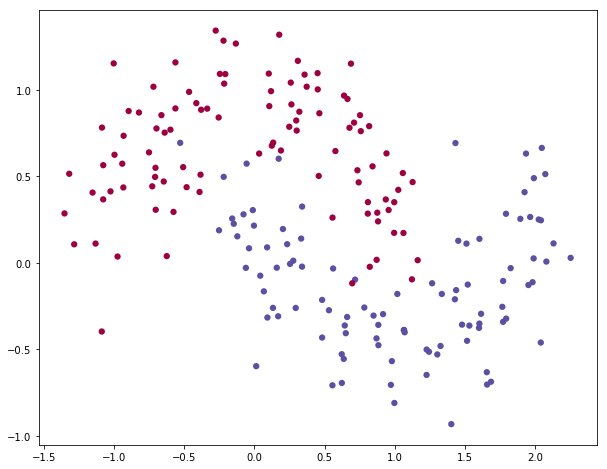

In [26]:
# Generate a dataset and plot it
np.random.seed(0)
train_X, train_y = sklearn.datasets.make_moons(200, noise=0.20)
train_X = train_X.astype(np.float32)
train_y = train_y.astype(np.int32)
plt.scatter(train_X[:,0], train_X[:,1], s=40, c=train_y, cmap=plt.cm.Spectral)

In [27]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = train_X[:, 0].min() - .5, train_X[:, 0].max() + .5
    y_min, y_max = train_X[:, 1].min() - .5, train_X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()].astype(np.float32))
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, cmap=plt.cm.Spectral)

In [28]:
# Size definitions
num_examples = len(train_X) # training set size
nn_input_dim = 2            # input layer dimensionality
nn_output_dim = 2           # output layer dimensionality
nn_hdim = 100               # hidden layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01     # learning rate for gradient descent
reg_lambda = 0.01  # regularization strength 

### Excercise 1: logistic regression

Train a logistic classifier on the dataset above, i.e. define an expression
that computes

> p = sigmoid(W * x + b)

where $W$ and $b$ are the parameters of the classifier and $x$ is the sample. If
$p > 0.5$ the sample is classified as class 2, otherwise as class 1. As the loss you
can use the binary crossentropy

> L = −t log(p)−(1−t) log(1−p)

#### Solution (scroll down)

* 
* 
* 
* 
* 
*
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
*
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
*
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
*
* 
* 
* 
* 
* 
* 
* 

In [52]:
x      = theano.tensor.fmatrix('x')
target = theano.tensor.ivector('target')
 
# define parameters to be optimized
W = theano.shared(np.random.randn(2).astype(np.float32), 'W')
b = theano.shared(np.float32(0), 'b')

# define probability
p = theano.tensor.nnet.sigmoid(W.dot(x.T) + b)

# define binary crossentropy
cost = -target * T.log(p) - (1-target) * T.log(1 - p)
cost = cost.mean()

# compute gradients
gradients = theano.tensor.grad(cost, [W, b])

# compute updates
W_updated = W - (np.float32(0.01) * gradients[0])
b_updated = b - (np.float32(0.01) * gradients[1])
updates   = [(W, W_updated), (b, b_updated)]

# compile function
f = theano.function([x, target], cost, updates=updates)

# compute accuracy
acc     = (p > 0.5) * target + (p < 0.5) * (1 - target)
acc     = acc.mean()
f_acc = theano.function([x, target], acc)

In [53]:
# training
for i in xrange(10000):
    f(train_X, train_y)
    if i%1000==0:
        print f_acc(train_X, train_y)

0.74
0.84
0.835
0.835
0.835
0.835
0.835
0.84
0.845
0.845


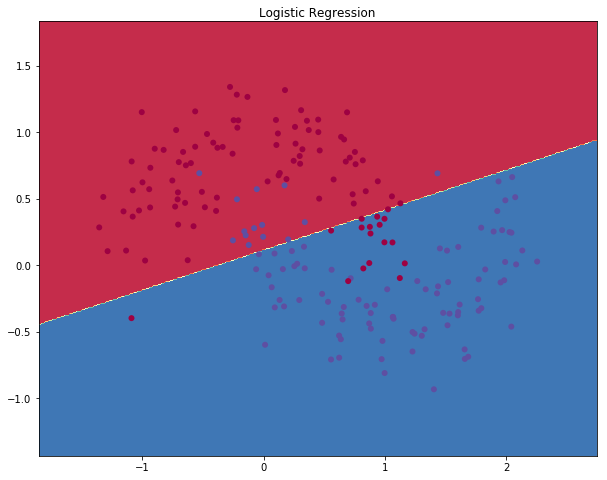

In [54]:
predict = theano.function([x], p > 0.5)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(x))
plt.title("Logistic Regression")
plt.show()

### Debugging hints

Now is a good time to get a sense of how Theano constructs a computational graph by visualising it.

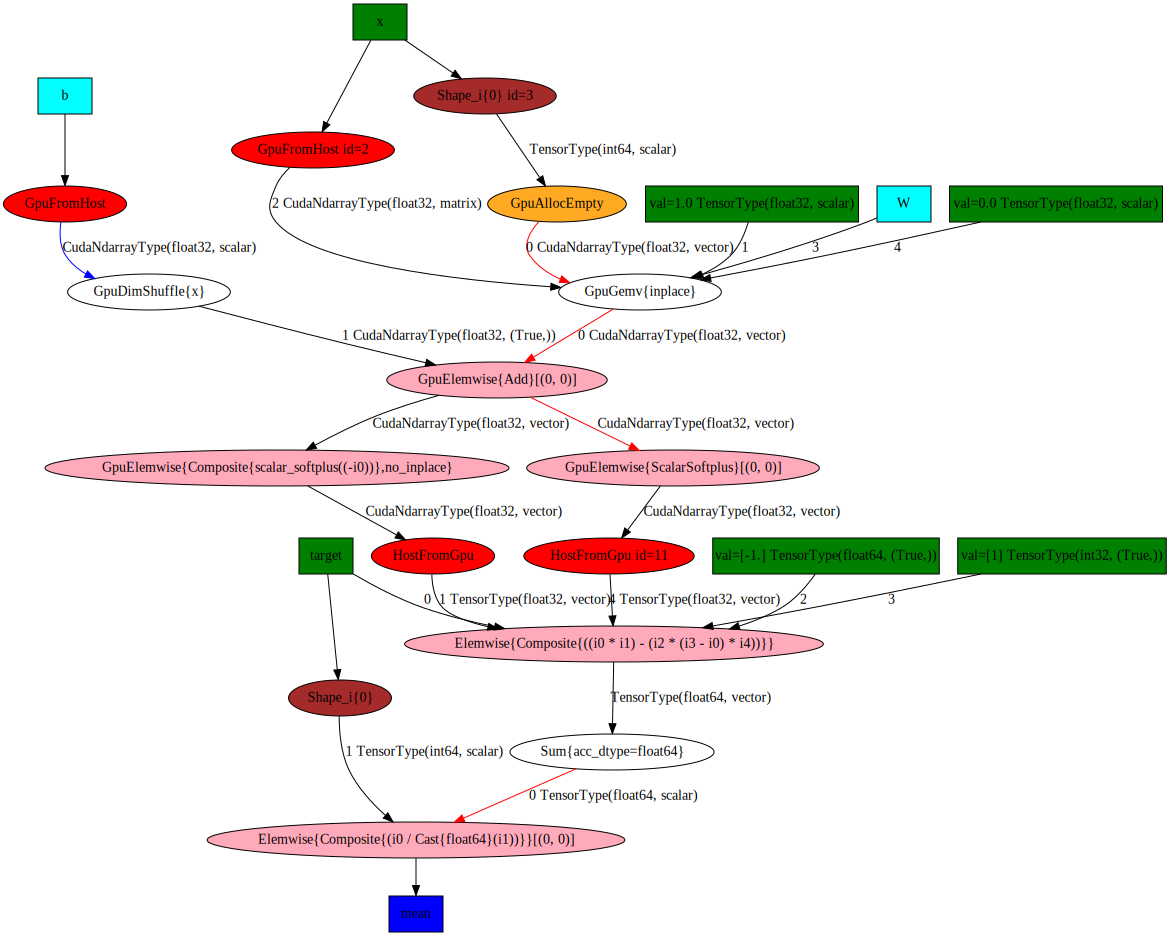

In [55]:
forward_prop = theano.function([x, target], cost)

SVG(theano.printing.pydotprint(forward_prop, var_with_name_simple=True, compact=True, return_image=True, format='svg'))

This is the *optimized* computational graph that Theano has constructed for our `forward_prop` function. We can also get a textual description:

In [56]:
theano.printing.debugprint(forward_prop)

Elemwise{Composite{(i0 / Cast{float64}(i1))}}[(0, 0)] [id A] 'mean'   14
 |Sum{acc_dtype=float64} [id B] ''   13
 | |Elemwise{Composite{((i0 * i1) - (i2 * (i3 - i0) * i4))}} [id C] ''   12
 |   |target [id D]
 |   |HostFromGpu [id E] ''   10
 |   | |GpuElemwise{Composite{scalar_softplus((-i0))},no_inplace} [id F] ''   8
 |   |   |GpuElemwise{Add}[(0, 0)] [id G] ''   7
 |   |     |GpuGemv{inplace} [id H] ''   6
 |   |     | |GpuAllocEmpty [id I] ''   5
 |   |     | | |Shape_i{0} [id J] ''   3
 |   |     | |   |x [id K]
 |   |     | |TensorConstant{1.0} [id L]
 |   |     | |GpuFromHost [id M] ''   2
 |   |     | | |x [id K]
 |   |     | |W [id N]
 |   |     | |TensorConstant{0.0} [id O]
 |   |     |GpuDimShuffle{x} [id P] ''   4
 |   |       |GpuFromHost [id Q] ''   1
 |   |         |b [id R]
 |   |TensorConstant{(1,) of -1.0} [id S]
 |   |TensorConstant{(1,) of 1} [id T]
 |   |HostFromGpu [id U] ''   11
 |     |GpuElemwise{ScalarSoftplus}[(0, 0)] [id V] ''   9
 |       |GpuElemwise{Add}

### Checking expressions on the fly

Theano allows us to define test values for each variable for which 
every expression is tested. Errors can thereby be identified immediately,
instead of coming up only after compilation.

In [57]:
# assign a test value to x (in this case the correct one)
x.tag.test_value = train_X
p = theano.tensor.nnet.sigmoid(W.dot(x.T) + b)

# enable on-the-fly graph computations
theano.config.compute_test_value = 'warn'

# assign a test value with wrong shape to x
x.tag.test_value = train_X.T
p = theano.tensor.nnet.sigmoid(W.dot(x.T) + b)

ValueError: shapes (2,) and (200,2) not aligned: 2 (dim 0) != 200 (dim 0)

In [63]:
# turn warnings off again for the rest of this notebook
theano.config.compute_test_value = 'off'

### Print intermediate values

Theano has the ability to print intermediate values to stdout during execution
of a function.

In [64]:
x_mean         = T.mean(x)
x_mean_printed = theano.printing.Print('This is the mean of x')(x_mean)

# add print to symbolic graph (without it doing anyting)
x_print        = x + 0 * x_mean_printed

# evaluate
T.mean(x_print).eval({x : train_X})

array(0.3723951578140259, dtype=float32)

### Profile your function

In order to profile the runtime of your function, use profile=True during
compilation.

In [65]:
# compile the function
f = theano.function([x, target], cost, updates=updates, profile=True)

# run the function multiple times
for _ in range(10):
    f(train_X, train_y)

In [66]:
f.profile.summary()

Function profiling
  Message: <ipython-input-65-cc7719d603b5>:2
  Time in 10 calls to Function.__call__: 1.227045e-02s
  Time in Function.fn.__call__: 1.190996e-02s (97.062%)
  Time in thunks: 7.454634e-03s (60.753%)
  Total compile time: 4.295568e-01s
    Number of Apply nodes: 28
    Theano Optimizer time: 2.507410e-01s
       Theano validate time: 6.445646e-03s
    Theano Linker time (includes C, CUDA code generation/compiling): 4.157209e-02s
       Import time 0.000000e+00s

Time in all call to theano.grad() 4.544401e-02s
Time since theano import 390.519s
Class
---
<% time> <sum %> <apply time> <time per call> <type> <#call> <#apply> <Class name>
  51.0%    51.0%       0.004s       9.51e-05s     C       40       4   theano.sandbox.cuda.basic_ops.GpuFromHost
  18.6%    69.6%       0.001s       2.77e-05s     C       50       5   theano.sandbox.cuda.basic_ops.GpuElemwise
   9.4%    79.0%       0.001s       2.33e-05s     C       30       3   theano.sandbox.cuda.basic_ops.HostFromGpu
  

### Using Lasagne

Lasagne helps with building neural networks capsulating the repetetive parts that occur when coding deeper architectures in Theano. E.g. the simple sigmoidal network above (for logistic regression) could be written in two lines:

In [67]:
import lasagne
import lasagne.layers as ll

# define the input of the network, i.e. its shape (where None stands for a 
# variable number, in this case the number of samples per batch is not fixed)
# and the theano variable that represents the input (optional)
net = ll.InputLayer(shape=(None,2), input_var=x)

# define a dense layer that takes the output x of the input layer and performs
# a dense affine transformation W*x + b together with a sigmoid nonlinearity
# num_units specifies the number of output units of that layer, which in turn
# (together with the input dimension) specifies the shape of W and b
net = ll.DenseLayer(net, num_units=1, nonlinearity=lasagne.nonlinearities.sigmoid)

The layers provide a high-level way of building your network architecture in Theano. The layers themselves are **not** Theano variables or expressions. Instead, they are used to build Theano expressions. To get the prediction of the network (i.e. the output after the dense layer) we need to call the helper function ll.get_output:

In [68]:
# prediction
p = ll.get_output(net)

# look at the types:
print type(net)
print type(p)

<class 'lasagne.layers.dense.DenseLayer'>
<class 'theano.tensor.var.TensorVariable'>


Lasagne implements different cost terms (see the - very readable! - [documentation](http://lasagne.readthedocs.io/en/latest/modules/objectives.html)), among them a binary cross_entropy cost:

In [69]:
cost = lasagne.objectives.binary_crossentropy(p.flatten(), target).mean()

# there is also a very simple way to compute the accuracy of the prediction
acc  = lasagne.objectives.binary_accuracy(p.flatten(), target).mean()

In order to compute the gradients we need the list of the parameters of the network:

In [70]:
params = ll.get_all_params(net)
print params

[W, b]


Finally, Lasagne also provides some convenience functions to compute the update expressions of the parameters for different update rules (e.g. plain stochastic gradient descent (SGD), Nesterov Momentum, Adagrad, Adam, etc.):

In [71]:
updates = lasagne.updates.momentum(cost, params, learning_rate=0.01)

# compile training function in the standard way
train_fn = theano.function([x, target], [cost, acc], updates=updates)

In [72]:
# training
for i in xrange(10000):
    vCost, vAcc = train_fn(train_X, train_y)
    if i%1000==0:
        print vAcc

0.79
0.845
0.855
0.85
0.845
0.845
0.845
0.845
0.845
0.845


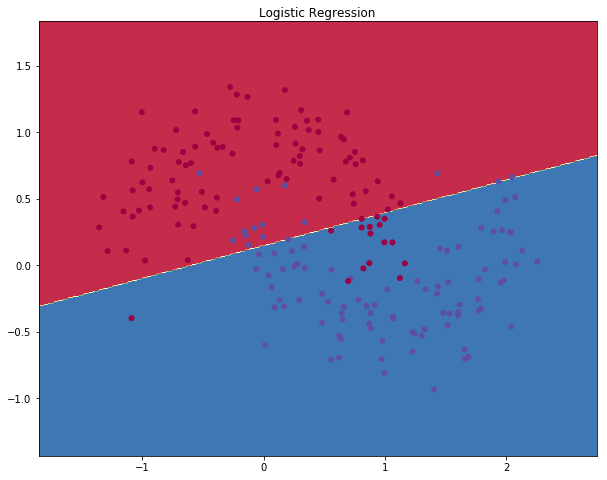

In [73]:
predict = theano.function([x], p > 0.5)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(x))
plt.title("Logistic Regression")
plt.show()

### Excercise 2

* Add additional layers to the network and observe the decision boundary
* Split the dataset into train and test set
* Evaluate training and test performance during training

### Solution

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

In [74]:
# split dataset
X_train, X_test = train_X[:150], train_X[150:]
y_train, y_test = train_y[:150], train_y[150:]

# define more flexible network
net = ll.InputLayer(shape=(None,2), input_var=x)
# the default nonlinearity is ReLU
net = ll.DenseLayer(net, num_units=10)
net = ll.DenseLayer(net, num_units=1, nonlinearity=lasagne.nonlinearities.sigmoid)

p = ll.get_output(net)

cost = lasagne.objectives.binary_crossentropy(p.flatten(), target).mean()
acc  = lasagne.objectives.binary_accuracy(p.flatten(), target).mean()

params = ll.get_all_params(net)
updates = lasagne.updates.momentum(cost, params, learning_rate=0.01)

# compile training function in the standard way
train_fn = theano.function([x, target], [cost, acc], updates=updates)

# compile separate test function that does not update parameters
test_fn = theano.function([x, target], [cost, acc])

In [75]:
data = {}
data['train_cost'] = []
data['test_cost'] = []
data['train_acc'] = []
data['test_acc'] = []

# training
for i in xrange(10000):
    vCost, vAcc = train_fn(X_train, y_train)
    if i%10==0:
        tCost, tAcc = test_fn(X_test, y_test)
        data['train_cost'].append(vCost)
        data['test_cost'].append(tCost)
        data['train_acc'].append(vAcc)
        data['test_acc'].append(tAcc)

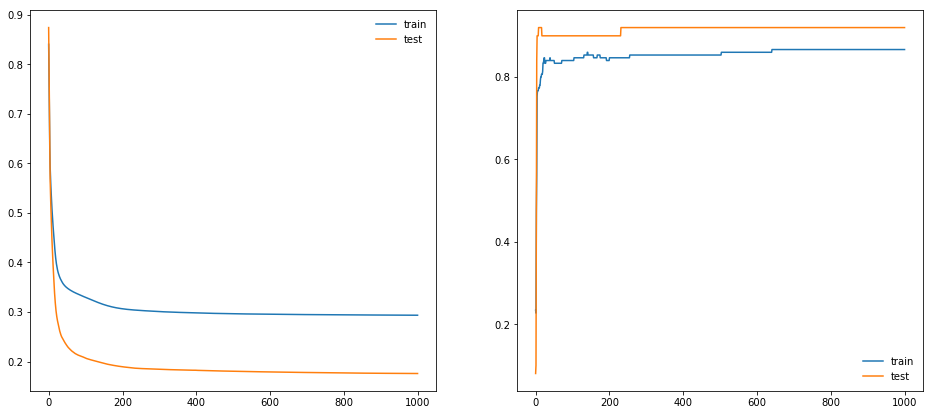

In [76]:
fig = plt.figure(figsize=(16,7))

plt.subplot(121)
plt.plot(data['train_cost'], label='train')
plt.plot(data['test_cost'], label='test')
plt.legend()

plt.subplot(122)
plt.plot(data['train_acc'], label='train')
plt.plot(data['test_acc'], label='test')
plt.legend()

plt.show()

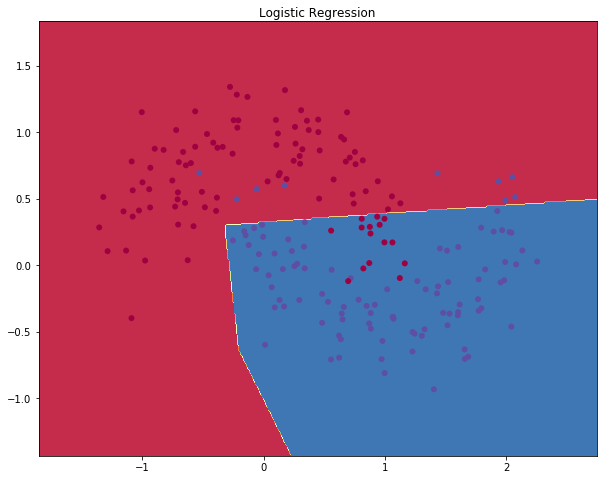

In [77]:
predict = theano.function([x], p > 0.5)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(x))
plt.title("Logistic Regression")
plt.show()

### Lasagne Hints

Lasagne has a very, very readable [documentation](http://lasagne.readthedocs.io/) and - even better - very readable and well organized source code! You should absolutely take a look.

**Initialization**

To specify how parameters should be initialized, use lasagne.init in the parameter definition of the layers:

> l = lasagne.layers.DenseLayer(l_in, num_units=100, W=lasagne.init.Normal(0.01))

You can also give a numpy array, a Theano shared variable or even a Theano expression! The latter can be useful if you want layers with shared parameters, or low-rank parameters.

**Network Parameters**

To save a network and its parameters you have two options: either pickle and save the whole network, or use ll.get_all_params(net) to get a list of numpy arrays with all parameters in it. To apply the list of parameters to another network, use ll.set_all_params(net).

**Deterministic Forward pass**

Some layers, like Dropout, induce randomness in the computations in order to regularize the training of the network. During test-time, however, we commonly want the computations to be deterministic, in which case we have to specify the output of the network to be deterministic:

> p = ll.get_output(net, deterministic=True)

**Traversing through the layers**

One way of "hopping" from one layer to its upstream layer is by calling net.input_layer.

**Output shape**

To see the shape of the output of a layer, call net.output_shape.

**Getting multiple expressions**

Sometimes one wants to get multiple output expressions. In this case, the most efficient way is to call ll.get_output on a list of layers:

> p, i = ll.get_output([net, net.input_layer])